In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
customer = pd.read_csv('Part A/customer_data.csv')
customer.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
0,1,Male,19,15,39,1.054960,0.036968,1
1,2,Male,21,15,81,0.676210,0.119785,1
2,3,Female,20,16,6,0.562232,0.010672,1
3,4,Female,23,16,77,1.284359,0.059952,1
4,5,Female,31,17,40,0.806683,0.049586,1


In [3]:
customer.describe()


,CustomerID,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000
mean,100.500000,38.850000,60.560000,50.200000,4.538022,0.015816,2.50000
std,57.879185,13.969007,26.264721,25.823522,2.214437,0.017091,1.12084
min,1.000000,18.000000,15.000000,1.000000,0.562232,0.000157,1.00000
25%,50.750000,28.750000,41.500000,34.750000,2.963534,0.008362,1.75000
50%,100.500000,36.000000,61.500000,50.000000,4.577495,0.012212,2.50000
75%,150.250000,49.000000,78.000000,73.000000,5.905840,0.015903,3.25000
max,200.000000,70.000000,137.000000,99.000000,11.133367,0.119785,4.00000


In [4]:
customer.isna().sum()

CustomerID                 0
Gender                     0
Age                        0
Income (k$)                0
How Much They Spend ($)    0
Salary (k$)                0
Spend to income ratio      0
Alpha                      0
dtype: int64

Transform the numerical features using StandardScaler to have 0 means and 1 variance

In [5]:
# Data Preprocessing
# copy the original DataFrame to avoid modifying it directly
customer_transform = customer.copy()
# remove unnecessary columns  
customer_transform.drop(columns=['CustomerID'], inplace=True)

# Transform numerical columns with StandardScaler
scaler = StandardScaler()
numerical_cols = customer_transform.select_dtypes(include=['int64', 'float64']).columns
customer_transform[numerical_cols] = scaler.fit_transform(customer_transform[numerical_cols]) 
# Transform categorical columns with one-hot encoding
categorical_cols = ["Gender"]
customer_transform = pd.get_dummies(customer_transform, columns=categorical_cols, drop_first=True)

customer_transform.head()


,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Gender_Male
0,-1.424569,-1.738999,-0.434801,-1.576835,1.240737,-1.341641,True
1,-1.281035,-1.738999,1.195704,-1.748301,6.098642,-1.341641,True
2,-1.352802,-1.700830,-1.715913,-1.799901,-0.301771,-1.341641,False
3,-1.137502,-1.700830,1.040418,-1.472983,2.588929,-1.341641,False
4,-0.563369,-1.662660,-0.395980,-1.689234,1.980859,-1.341641,False


In [6]:
customer_transform.describe()

,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,200.000000,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16,-7.105427e-17,0.000000,-7.105427e-17
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00,-1.799901e+00,-0.918524,-1.341641e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01,-7.127949e-01,-0.437284,-6.708204e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03,1.786994e-02,-0.211444,0.000000e+00
75%,7.284319e-01,6.656748e-01,8.851316e-01,6.192318e-01,0.005085,6.708204e-01
max,2.235532e+00,2.917671e+00,1.894492e+00,2.985813e+00,6.098642,1.341641e+00


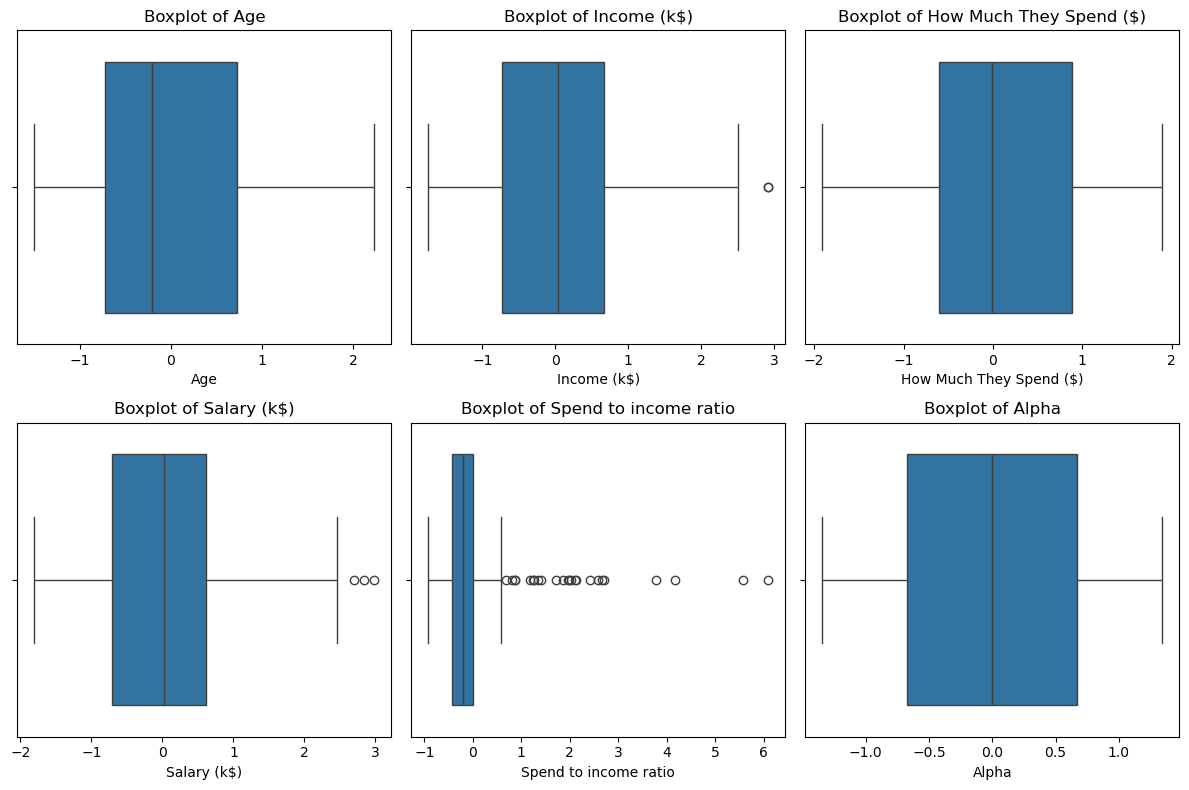

In [7]:
# Plotting the numerical features to visualize outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=customer_transform[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# choosing n_clusters using the elbow method

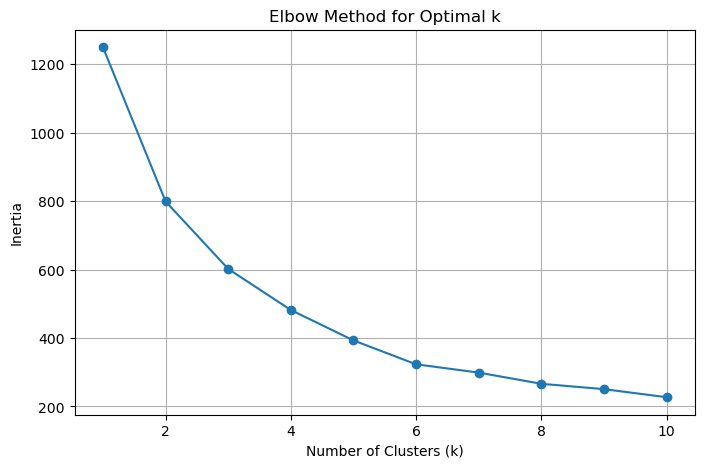

In [8]:
# choosing n_clusters using the elbow method
inertia = []
for i in range(1, 11):
    model = KMeans(n_clusters=i, random_state=42)
    model.fit(customer_transform)
    inertia.append(model.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [9]:
KMeans(n_clusters=5, random_state=42).fit(customer_transform)

KMeans(n_clusters=5, random_state=42)

In [10]:
# Only select numerical columns for distance calculation
customer_transform = customer_transform.select_dtypes(include=['float64', 'bool']).astype(float)

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(customer_transform)
    distortions.append(sum(np.min(cdist(customer_transform, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / customer_transform.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

Distortion values:
1 : 6.246399999999999
2 : 3.993974002250099
3 : 3.0090533557254746
4 : 2.409006059069258
5 : 1.9649443127869315
6 : 1.6161449638524197
7 : 1.49473200100746
8 : 1.3314350833592774
9 : 1.253302051426047


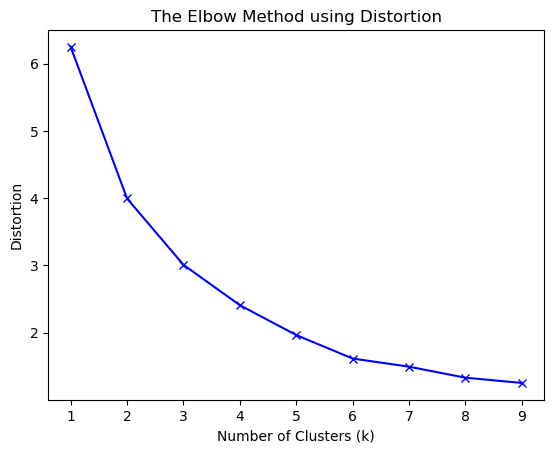

In [11]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Inertia values:
1 : 1249.28
2 : 798.7948004500198
3 : 601.810671145095
4 : 481.80121181385147
5 : 392.98886255738626
6 : 323.2289927704836
7 : 298.9464002014919
8 : 266.28701667185555
9 : 250.6604102852094


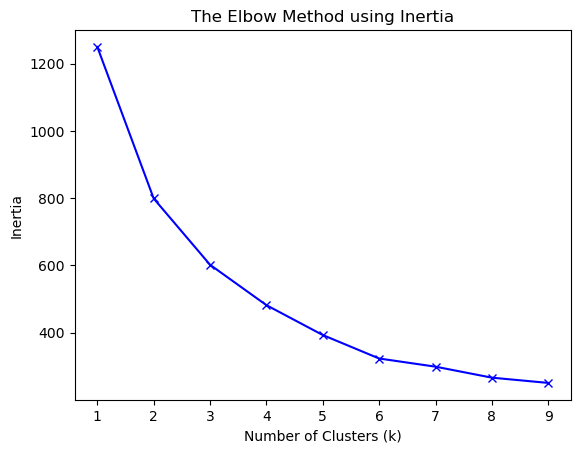

In [12]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

# Anomaly

KMeans(n_clusters=6)


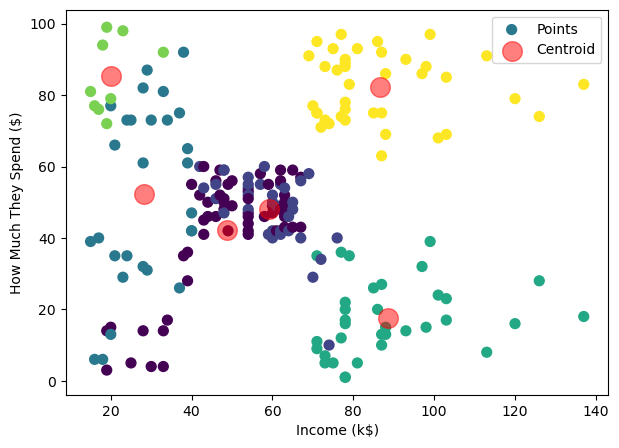

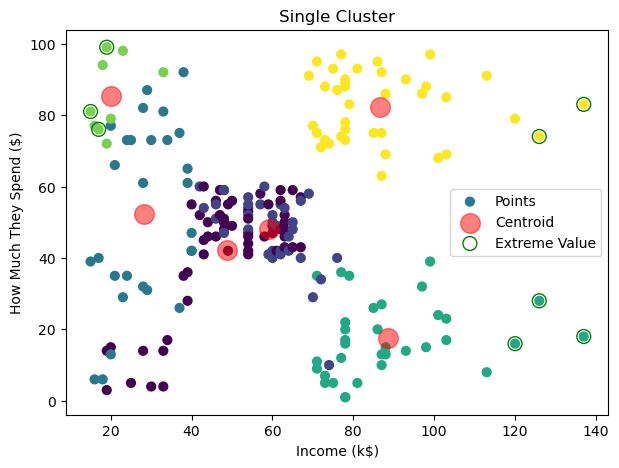

Anomalies from the original data:
     CustomerID  Gender  Age  Income (k$)  How Much They Spend ($)  \
1             2    Male   21           15                       81   
5             6  Female   22           17                       76   
11           12  Female   35           19                       99   
194         195  Female   47          120                       16   
196         197  Female   45          126                       28   
197         198    Male   32          126                       74   
198         199    Male   32          137                       18   
199         200    Male   30          137                       83   

     Salary (k$)  Spend to income ratio  Alpha  
1       0.676210               0.119785      1  
5       0.873059               0.087050      1  
11      0.893771               0.110767      1  
194     9.770024               0.001638      4  
196     9.966931               0.002809      4  
197    10.497569               0.007049  

In [13]:
def anomalies_idx(cluster, distances, n_anomalies = 5):
  idx = []
  for i in range(cluster):
    idx.append(np.argsort(distances[:,i].ravel())[::-1][:n_anomalies])
  idx = np.array(idx)
  # flatten the idx array and remove duplicates
  idx = np.unique(idx.flatten())
  return idx

# Anomaly Detection using KMeans
cluster = 6

kmeans = KMeans(n_clusters=cluster)
kmeans.fit(customer_transform)
print(kmeans)
# Visualize the results
import matplotlib.pyplot as plt
y_kmeans = kmeans.predict(customer_transform)
# scatter plot the data points
f, ax = plt.subplots(figsize=(7, 5))
ax.scatter(customer["Income (k$)"], customer["How Much They Spend ($)"], c=y_kmeans, s=50, cmap='viridis',label='Points')
# show centroid centres as red circle opacity 50%
centers = kmeans.cluster_centers_
centers_inv = scaler.inverse_transform(centers[:,:-1]) 
ax.scatter(centers_inv[:, 1], centers_inv[:, 2], label='Centroid', color='r', s=200, alpha=0.5)
ax.legend()
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend ($)")
plt.show()


# argsort returns an array of indexes which will sort the array in
# ascending order
# so we reverse it via [::-1] and take the top five with [:5]
distances = kmeans.transform(customer_transform)
sorted_idx = anomalies_idx(cluster, distances, n_anomalies = 3)
# Now let's see which are the top n_anomalies points furthest away
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Single Cluster")
ax.scatter(customer["Income (k$)"], customer["How Much They Spend ($)"], c=y_kmeans, s=40, cmap='viridis',label='Points')
ax.scatter(centers_inv[:, 1], centers_inv[:, 2], label='Centroid', color='r', s=200, alpha=0.5)
ax.scatter(customer.iloc[sorted_idx]['Income (k$)'], 
           customer.iloc[sorted_idx]["How Much They Spend ($)"], 
           label='Extreme Value', edgecolors='g', facecolors='none', s=100)
ax.legend(loc='best')
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend ($)")
plt.show()
# It's easy to remove these points if we like:
# new_Customer = np.delete(customer_transform, sorted_idx, axis=0)
new_Customer_transformed = customer_transform.drop(customer_transform.index[sorted_idx])
new_Customer = customer_transform.drop(customer.index[sorted_idx])
# Or to extract the anomalies
anomaly = customer.iloc[sorted_idx]
anomaly_transformed = customer_transform.iloc[sorted_idx]
print("Anomalies from the original data:")
print(anomaly)